In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from itertools import chain
import seaborn as sns
from datetime import datetime

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import resample_img
from nilearn.image import new_img_like, load_img, clean_img, crop_img
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import torch.optim as optim
import h5py
from torchsummary import summary
from tensorboardX import SummaryWriter

from IPython import display
%matplotlib inline

In [2]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class MyDataset(Dataset):
    def __init__(self, task_type, test_size=0.2, test=False, scaler='minmax',
                path='../../brainmask_tlrc/*.npy'):

        self.scaler = scaler

        RANDOM_STATE = 42
        np.random.seed(RANDOM_STATE)

        data_files = glob(path)
        data_files.sort()
        
#         label_file = pd.read_csv('../rsc/age_ixi_and_oasis.csv', index_col=0)
        label_file = pd.read_csv('../rsc/age_ixioasdlbs.csv', index_col=0)
        
        idx = label_file[label_file.src.map(lambda x: x not in ['Oasis3'])].index
        data_files = np.array(glob('../../brainmask_tlrc/*.npy'))
        data_files.sort()
        data_files = data_files[idx].tolist()

        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))

        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname = [data_files[i] for i in shuffled_index[-test_num:]]
        

        if test:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file[task_type].values[shuffled_index[-test_num:]]
            self.fname = label_file['id'].values[shuffled_index[-test_num:]]

        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file[task_type].values[shuffled_index[:train_num]]
            self.fname = label_file['id'].values[shuffled_index[:train_num]]

    def __getitem__(self, idx):
        
        if self.scaler == 'minmax':
            x = np.load(self.data_files[idx])
            x = MinMaxScaler().fit_transform(x.reshape(-1, 1)).reshape(141, 172, 110)

        else:
            x = np.load(self.data_files[idx])
            
        x = torch.tensor(x)[None, :, :].float()
        y = torch.tensor(self.label_file[idx]).float()
        
        return x, y

    def __len__(self):
        return len(self.data_files)

In [3]:
train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

In [4]:
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F


def get_inplanes():
#     return [64, 128, 256, 512]
#     return [16, 32, 64, 128]
    return [8, 16, 32, 64]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=400):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [5]:
class Option:
    
    def __init__(self, model_depth=10,
                n_classes=1,
                n_input_channels=1,
                conv1_t_size=3,
                conv1_t_stride=1,
                no_max_pool=False,
                resnet_widen_factor=1.0
                ):
        
        self.model_depth = model_depth
        self.n_classes = n_classes
        self.n_input_channels = n_input_channels
        self.conv1_t_size = conv1_t_size
        self.conv1_t_stride = conv1_t_stride
        self.no_max_pool = no_max_pool
        self.resnet_widen_factor = resnet_widen_factor

opt = Option()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = generate_model(model_depth=opt.model_depth,
                              n_classes=opt.n_classes,
                              n_input_channels=opt.n_input_channels,
                              shortcut_type='A',
                              conv1_t_size=opt.conv1_t_size,
                              conv1_t_stride=opt.conv1_t_stride,
                              no_max_pool=opt.no_max_pool,
                              widen_factor=opt.resnet_widen_factor)
model.to(device)

summary(model, input_size=(1, 96, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 96, 48, 48]           1,176
       BatchNorm3d-2        [-1, 8, 96, 48, 48]              16
              ReLU-3        [-1, 8, 96, 48, 48]               0
         MaxPool3d-4        [-1, 8, 48, 24, 24]               0
            Conv3d-5        [-1, 8, 48, 24, 24]           1,728
       BatchNorm3d-6        [-1, 8, 48, 24, 24]              16
              ReLU-7        [-1, 8, 48, 24, 24]               0
            Conv3d-8        [-1, 8, 48, 24, 24]           1,728
       BatchNorm3d-9        [-1, 8, 48, 24, 24]              16
             ReLU-10        [-1, 8, 48, 24, 24]               0
       BasicBlock-11        [-1, 8, 48, 24, 24]               0
           Conv3d-12       [-1, 16, 24, 12, 12]           3,456
      BatchNorm3d-13       [-1, 16, 24, 12, 12]              32
             ReLU-14       [-1, 16, 24,

In [6]:
task_type = 'age'
resize = True
scheduler = False

summary = SummaryWriter(f'./tensorboard/{datetime.now().strftime("%Y-%m-%d_%H%M")}')

In [7]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [8]:
LOSS = {
    'RMSE': RMSELoss(),
    'MSE': nn.MSELoss(),
}

In [9]:
# loss_fn = nn.MSELoss()
loss = 'RMSE'

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS 0
L1   :: [TRAIN] 3600.192 | [VALID] 3552.762
CORR :: [TRAIN] 0.381 | [VALID] 0.562


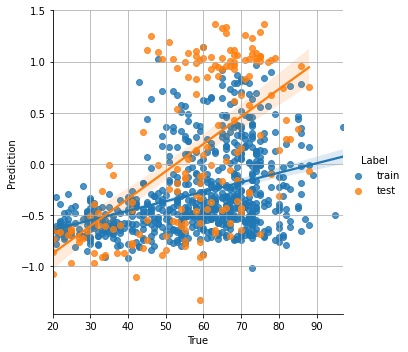

EPOCHS 1
L1   :: [TRAIN] 3516.980 | [VALID] 3558.774
CORR :: [TRAIN] 0.647 | [VALID] 0.645


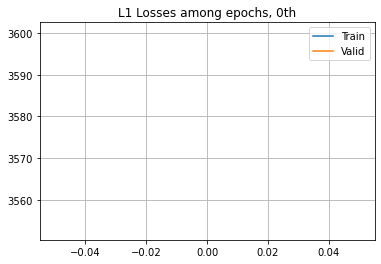

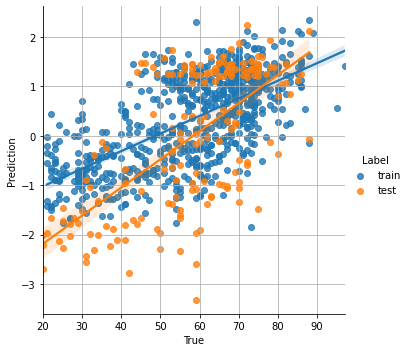

EPOCHS 2
L1   :: [TRAIN] 3461.193 | [VALID] 3446.108
CORR :: [TRAIN] 0.689 | [VALID] 0.675


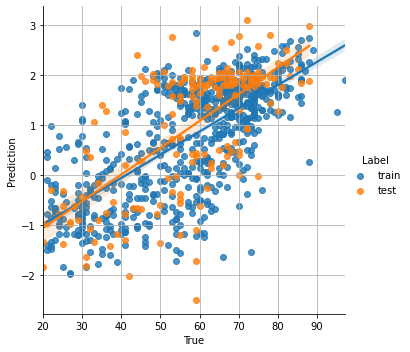

EPOCHS 3
L1   :: [TRAIN] 3412.937 | [VALID] 3374.676
CORR :: [TRAIN] 0.700 | [VALID] 0.685


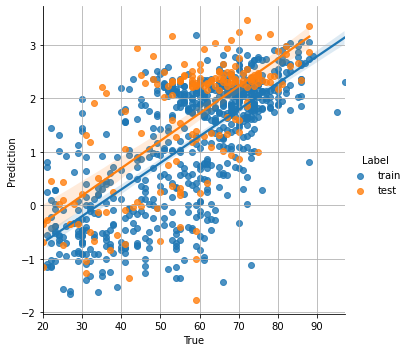

EPOCHS 4
L1   :: [TRAIN] 3366.771 | [VALID] 3333.855
CORR :: [TRAIN] 0.711 | [VALID] 0.703


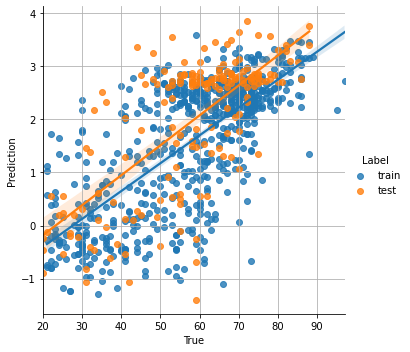

EPOCHS 5
L1   :: [TRAIN] 3320.609 | [VALID] 3278.439
CORR :: [TRAIN] 0.723 | [VALID] 0.719


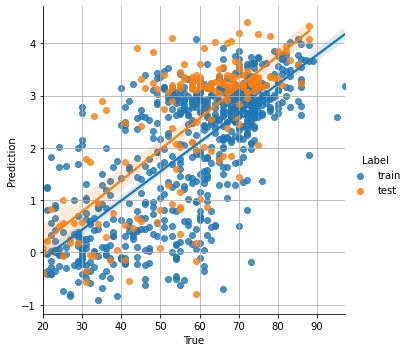

EPOCHS 6
L1   :: [TRAIN] 3273.224 | [VALID] 3238.062
CORR :: [TRAIN] 0.735 | [VALID] 0.730


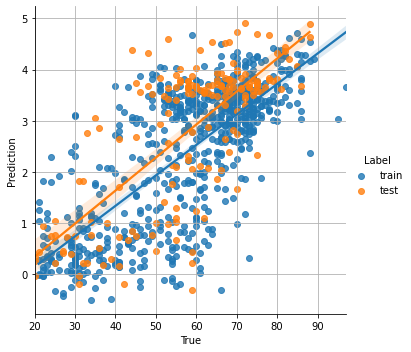

EPOCHS 7
L1   :: [TRAIN] 3225.636 | [VALID] 3194.907
CORR :: [TRAIN] 0.749 | [VALID] 0.739


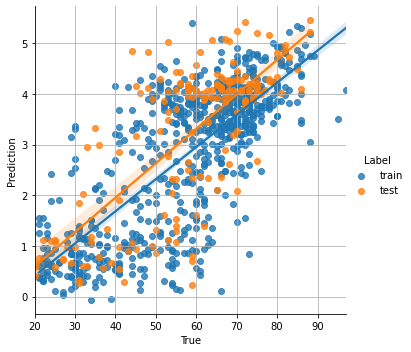

EPOCHS 8
L1   :: [TRAIN] 3177.015 | [VALID] 3153.329
CORR :: [TRAIN] 0.762 | [VALID] 0.747


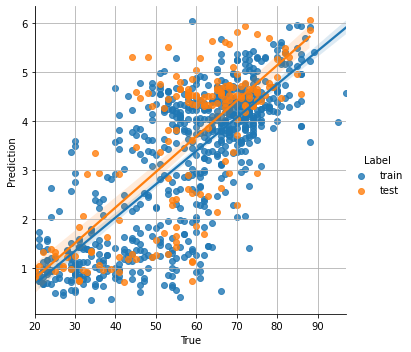

EPOCHS 9
L1   :: [TRAIN] 3125.971 | [VALID] 3090.943
CORR :: [TRAIN] 0.773 | [VALID] 0.757


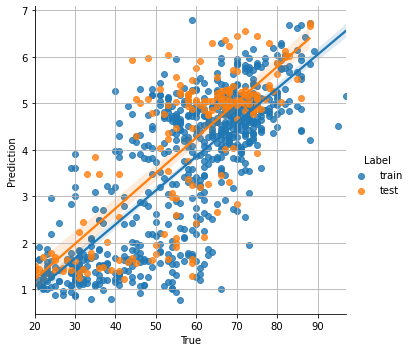

EPOCHS 10
L1   :: [TRAIN] 3072.867 | [VALID] 3023.059
CORR :: [TRAIN] 0.781 | [VALID] 0.763


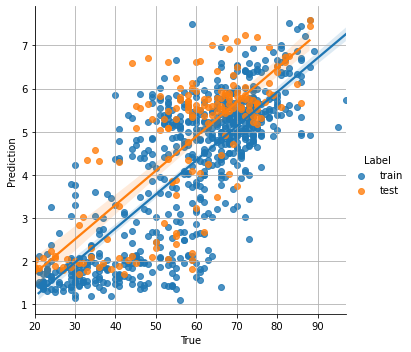

EPOCHS 11
L1   :: [TRAIN] 3017.735 | [VALID] 2964.525
CORR :: [TRAIN] 0.791 | [VALID] 0.769


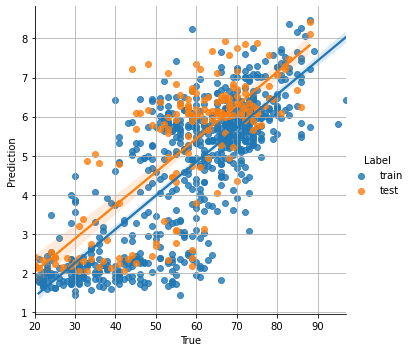

EPOCHS 12
L1   :: [TRAIN] 2959.324 | [VALID] 2915.941
CORR :: [TRAIN] 0.802 | [VALID] 0.771


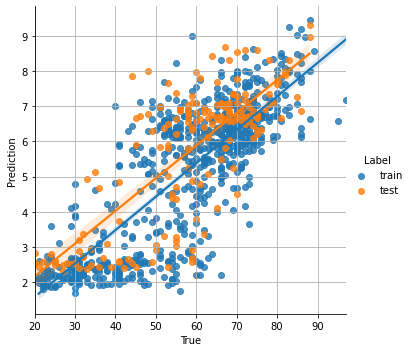

EPOCHS 13
L1   :: [TRAIN] 2898.481 | [VALID] 2873.172
CORR :: [TRAIN] 0.814 | [VALID] 0.763


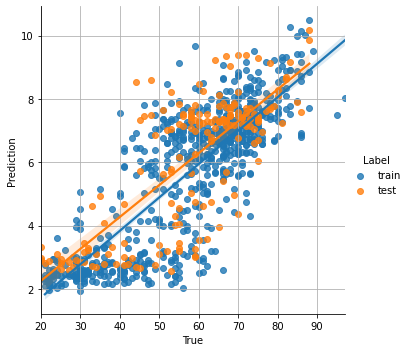

EPOCHS 14
L1   :: [TRAIN] 2835.686 | [VALID] 2812.986
CORR :: [TRAIN] 0.827 | [VALID] 0.765


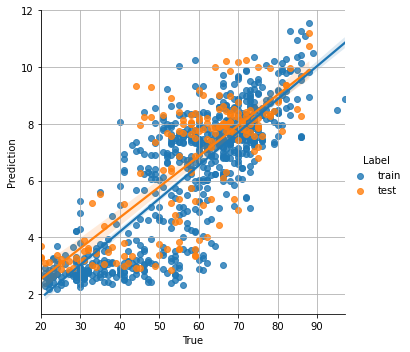

EPOCHS 15
L1   :: [TRAIN] 2770.742 | [VALID] 2742.783
CORR :: [TRAIN] 0.840 | [VALID] 0.764


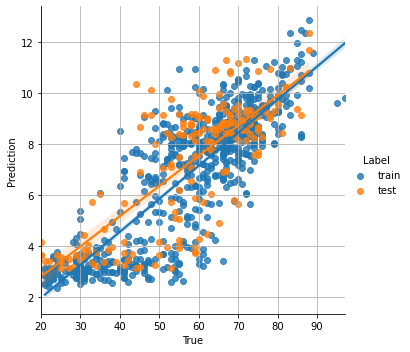

EPOCHS 16
L1   :: [TRAIN] 2703.571 | [VALID] 2711.129
CORR :: [TRAIN] 0.853 | [VALID] 0.728


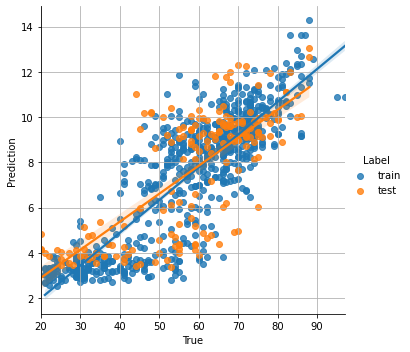

EPOCHS 17
L1   :: [TRAIN] 2634.567 | [VALID] 2665.654
CORR :: [TRAIN] 0.866 | [VALID] 0.687


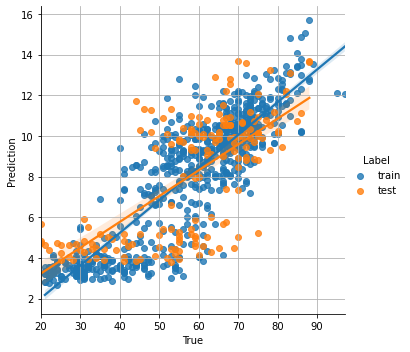

EPOCHS 18
L1   :: [TRAIN] 2562.678 | [VALID] 2598.653
CORR :: [TRAIN] 0.878 | [VALID] 0.671


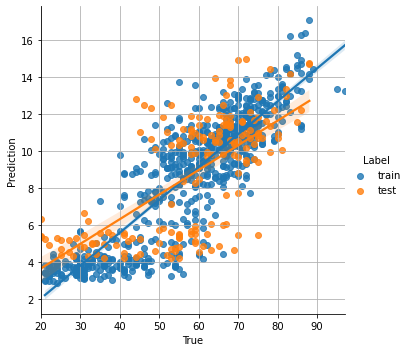

EPOCHS 19
L1   :: [TRAIN] 2488.519 | [VALID] 2547.202
CORR :: [TRAIN] 0.888 | [VALID] 0.636


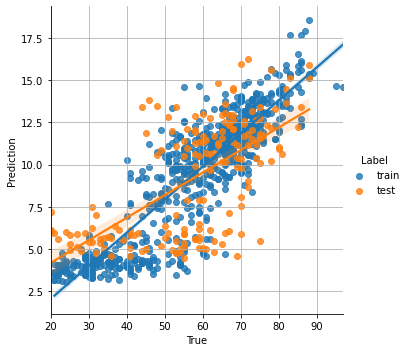

EPOCHS 20
L1   :: [TRAIN] 2414.666 | [VALID] 2496.682
CORR :: [TRAIN] 0.896 | [VALID] 0.581


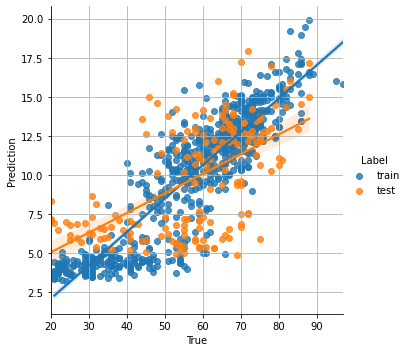

EPOCHS 21
L1   :: [TRAIN] 2341.440 | [VALID] 2443.097
CORR :: [TRAIN] 0.902 | [VALID] 0.519


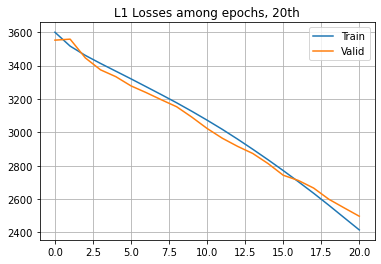

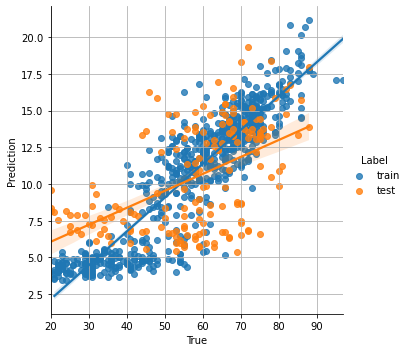

EPOCHS 22
L1   :: [TRAIN] 2268.773 | [VALID] 2387.509
CORR :: [TRAIN] 0.907 | [VALID] 0.472


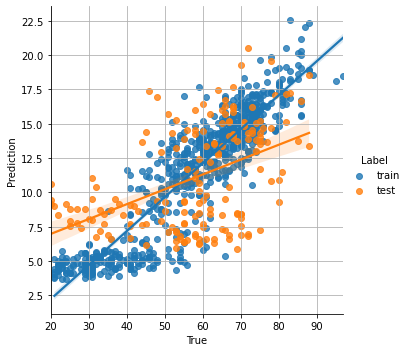

EPOCHS 23
L1   :: [TRAIN] 2197.322 | [VALID] 2355.548
CORR :: [TRAIN] 0.910 | [VALID] 0.436


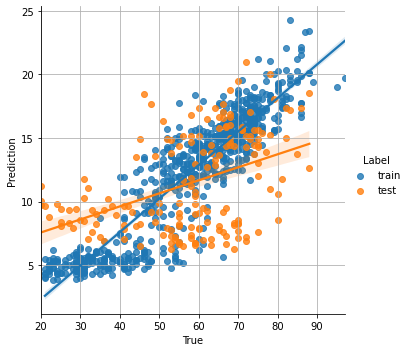

EPOCHS 24
L1   :: [TRAIN] 2126.871 | [VALID] 2271.294
CORR :: [TRAIN] 0.911 | [VALID] 0.658


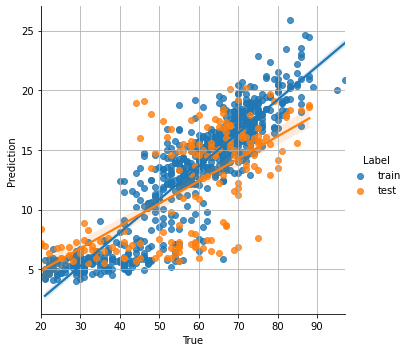

EPOCHS 25
L1   :: [TRAIN] 2056.808 | [VALID] 2251.901
CORR :: [TRAIN] 0.909 | [VALID] 0.752


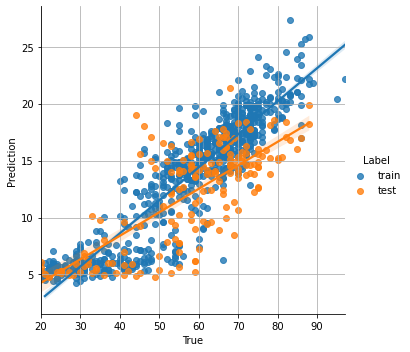

EPOCHS 26
L1   :: [TRAIN] 1987.302 | [VALID] 2151.649
CORR :: [TRAIN] 0.909 | [VALID] 0.712


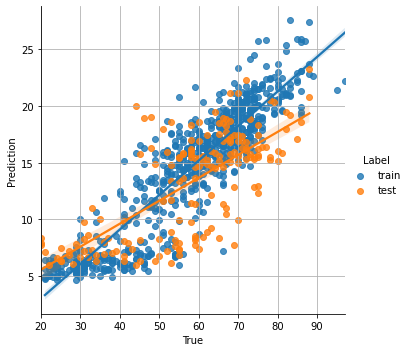

EPOCHS 27
L1   :: [TRAIN] 1915.229 | [VALID] 1929.754
CORR :: [TRAIN] 0.918 | [VALID] 0.766


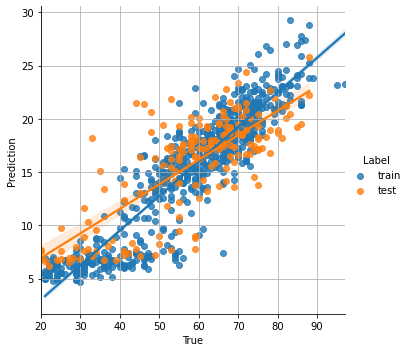

EPOCHS 28
L1   :: [TRAIN] 1845.833 | [VALID] 1758.018
CORR :: [TRAIN] 0.920 | [VALID] 0.723


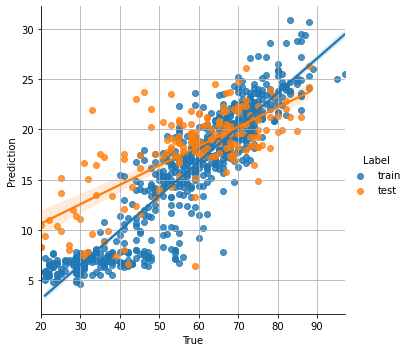

EPOCHS 29
L1   :: [TRAIN] 1776.398 | [VALID] 1641.972
CORR :: [TRAIN] 0.923 | [VALID] 0.618


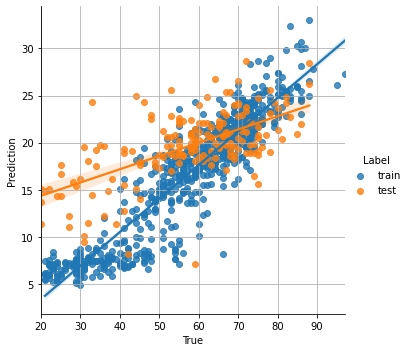

EPOCHS 30
L1   :: [TRAIN] 1707.292 | [VALID] 1503.792
CORR :: [TRAIN] 0.926 | [VALID] 0.598


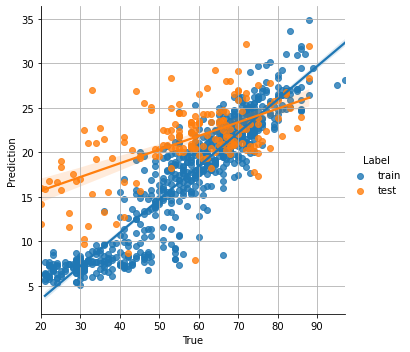

EPOCHS 31
L1   :: [TRAIN] 1639.802 | [VALID] 1380.625
CORR :: [TRAIN] 0.928 | [VALID] 0.638


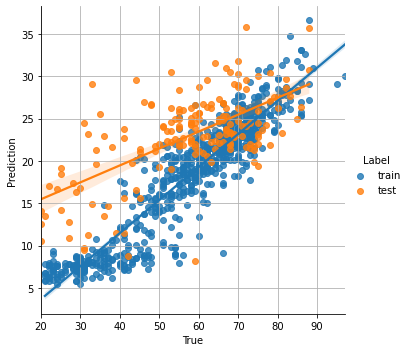

EPOCHS 32
L1   :: [TRAIN] 1573.881 | [VALID] 1435.434
CORR :: [TRAIN] 0.930 | [VALID] 0.748


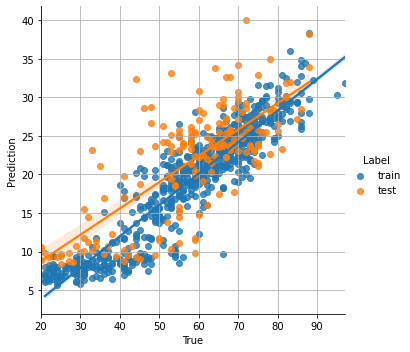

EPOCHS 33
L1   :: [TRAIN] 1509.078 | [VALID] 1578.248
CORR :: [TRAIN] 0.932 | [VALID] 0.674


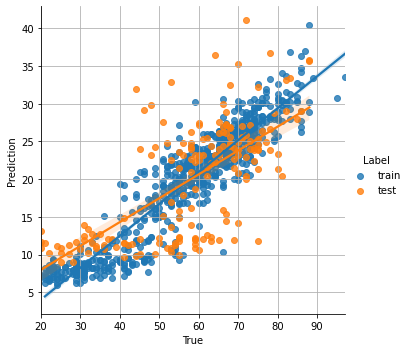

EPOCHS 34
L1   :: [TRAIN] 1445.345 | [VALID] 1658.851
CORR :: [TRAIN] 0.933 | [VALID] 0.566


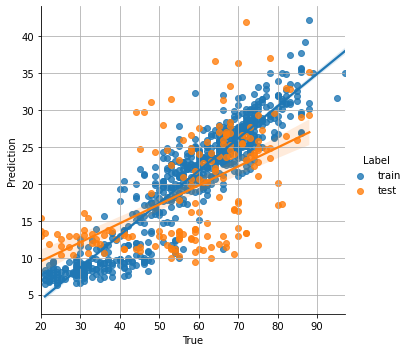

EPOCHS 35
L1   :: [TRAIN] 1382.536 | [VALID] 1457.323
CORR :: [TRAIN] 0.933 | [VALID] 0.678


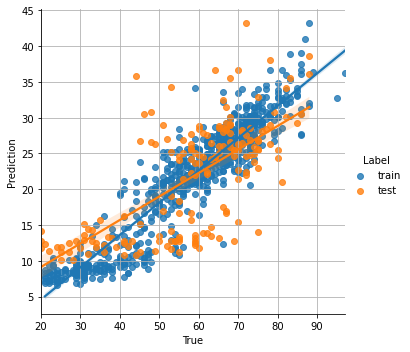

EPOCHS 36
L1   :: [TRAIN] 1323.659 | [VALID] 1197.073
CORR :: [TRAIN] 0.931 | [VALID] 0.630


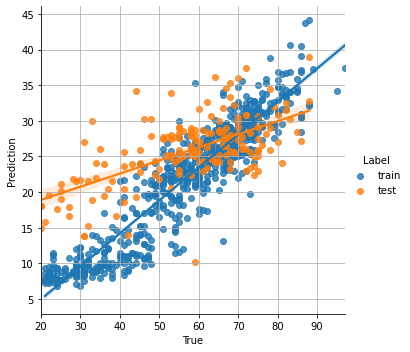

EPOCHS 37
L1   :: [TRAIN] 1259.036 | [VALID] 1516.121
CORR :: [TRAIN] 0.937 | [VALID] 0.654


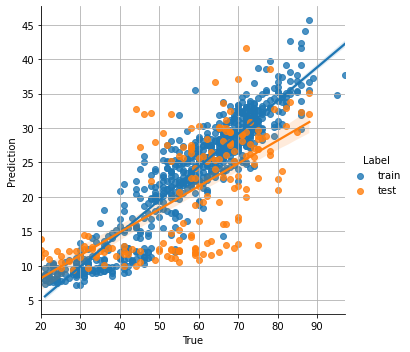

EPOCHS 38
L1   :: [TRAIN] 1199.113 | [VALID] 1507.934
CORR :: [TRAIN] 0.940 | [VALID] 0.595


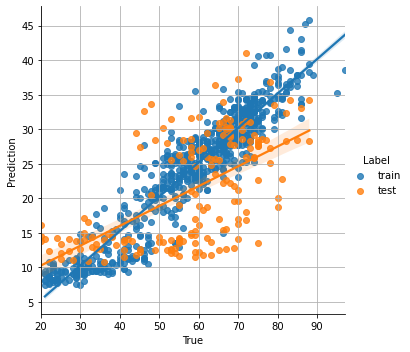

EPOCHS 39
L1   :: [TRAIN] 1141.084 | [VALID] 1318.715
CORR :: [TRAIN] 0.942 | [VALID] 0.701


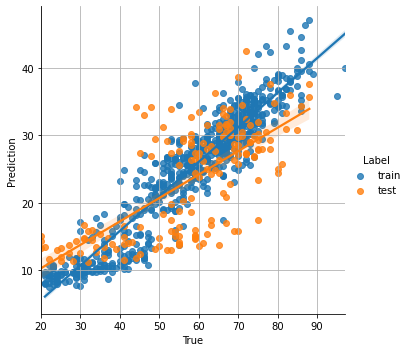

EPOCHS 40
L1   :: [TRAIN] 1084.989 | [VALID] 1185.702
CORR :: [TRAIN] 0.943 | [VALID] 0.736


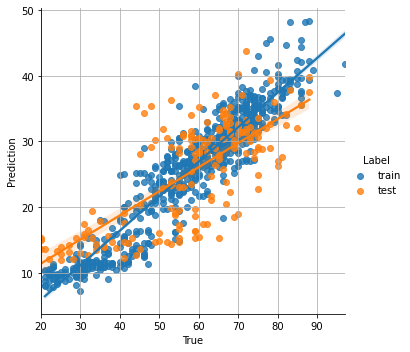

EPOCHS 41
L1   :: [TRAIN] 1031.382 | [VALID] 1046.383
CORR :: [TRAIN] 0.942 | [VALID] 0.779


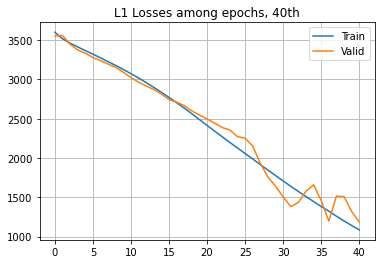

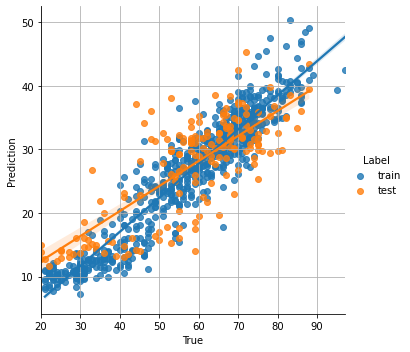

EPOCHS 42
L1   :: [TRAIN] 977.967 | [VALID] 894.180
CORR :: [TRAIN] 0.942 | [VALID] 0.753


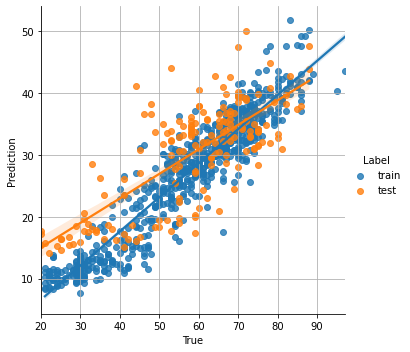

EPOCHS 43
L1   :: [TRAIN] 928.470 | [VALID] 1069.383
CORR :: [TRAIN] 0.939 | [VALID] 0.679


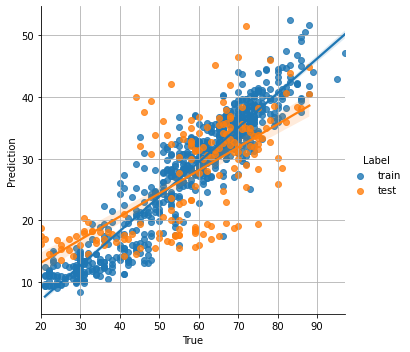

EPOCHS 44
L1   :: [TRAIN] 880.823 | [VALID] 1297.971
CORR :: [TRAIN] 0.941 | [VALID] 0.617


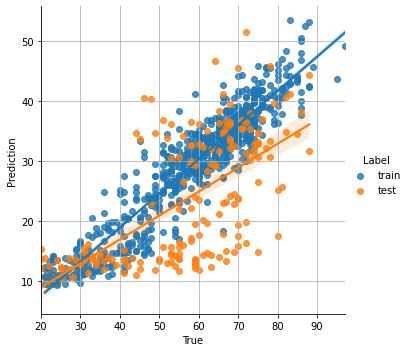

EPOCHS 45
L1   :: [TRAIN] 829.808 | [VALID] 1376.467
CORR :: [TRAIN] 0.946 | [VALID] 0.515


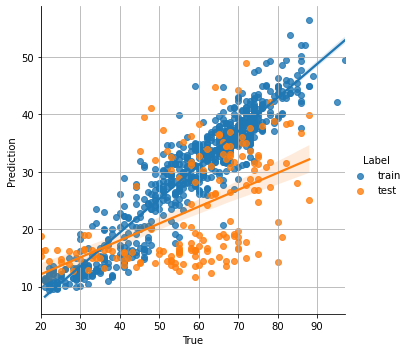

EPOCHS 46
L1   :: [TRAIN] 780.107 | [VALID] 1183.829
CORR :: [TRAIN] 0.949 | [VALID] 0.595


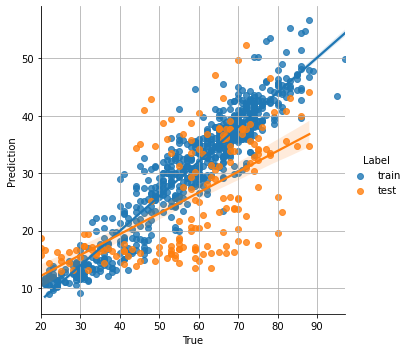

EPOCHS 47
L1   :: [TRAIN] 732.398 | [VALID] 1062.883
CORR :: [TRAIN] 0.951 | [VALID] 0.577


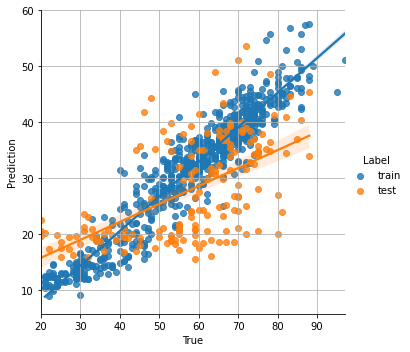

EPOCHS 48
L1   :: [TRAIN] 686.353 | [VALID] 1123.121
CORR :: [TRAIN] 0.952 | [VALID] 0.453


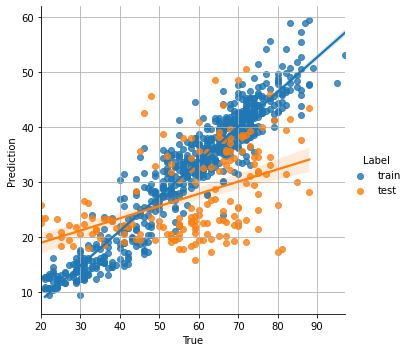

EPOCHS 49
L1   :: [TRAIN] 644.333 | [VALID] 1252.918
CORR :: [TRAIN] 0.953 | [VALID] 0.279


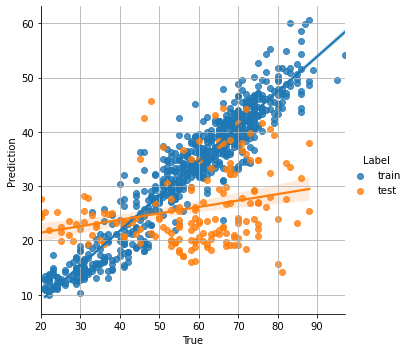

EPOCHS 50
L1   :: [TRAIN] 602.960 | [VALID] 1339.811
CORR :: [TRAIN] 0.954 | [VALID] 0.037


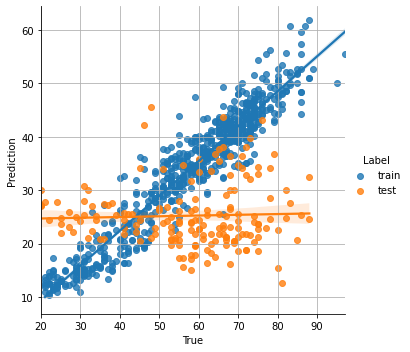

EPOCHS 51
L1   :: [TRAIN] 562.690 | [VALID] 1235.927
CORR :: [TRAIN] 0.955 | [VALID] 0.130


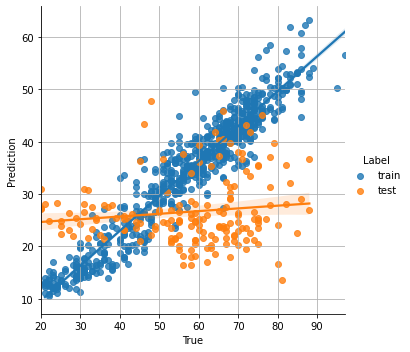

EPOCHS 52
L1   :: [TRAIN] 523.507 | [VALID] 876.093
CORR :: [TRAIN] 0.956 | [VALID] 0.593


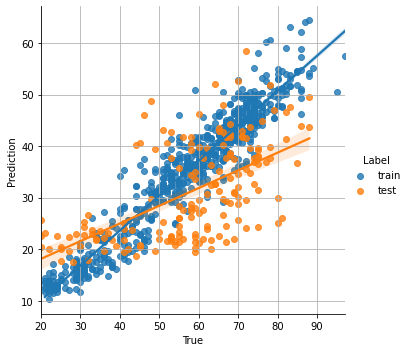

EPOCHS 53
L1   :: [TRAIN] 485.867 | [VALID] 536.052
CORR :: [TRAIN] 0.956 | [VALID] 0.787


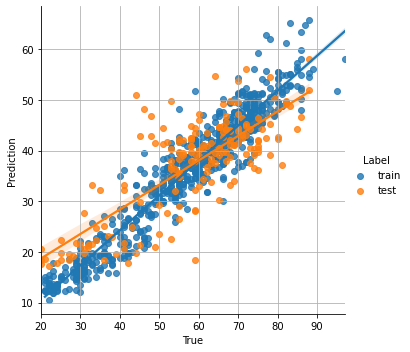

EPOCHS 54
L1   :: [TRAIN] 450.061 | [VALID] 484.986
CORR :: [TRAIN] 0.956 | [VALID] 0.782


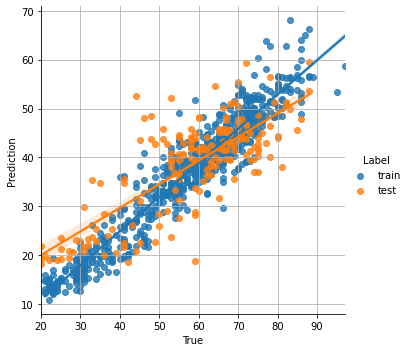

EPOCHS 55
L1   :: [TRAIN] 416.459 | [VALID] 476.912
CORR :: [TRAIN] 0.956 | [VALID] 0.759


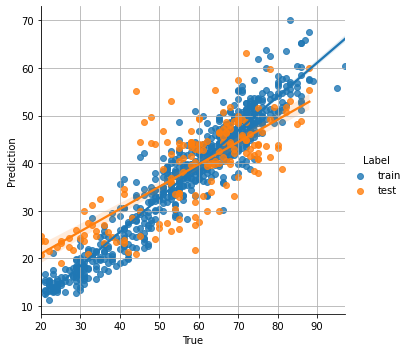

EPOCHS 56
L1   :: [TRAIN] 386.075 | [VALID] 542.128
CORR :: [TRAIN] 0.955 | [VALID] 0.634


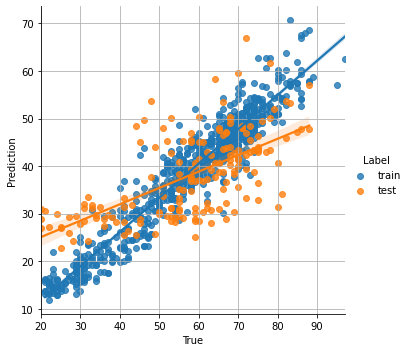

EPOCHS 57
L1   :: [TRAIN] 357.523 | [VALID] 554.065
CORR :: [TRAIN] 0.954 | [VALID] 0.596


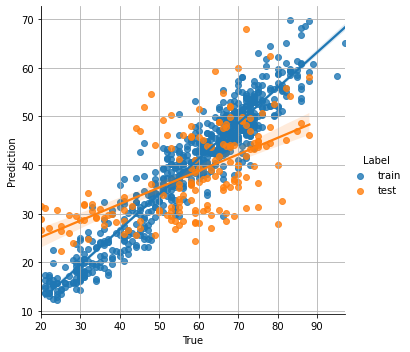

EPOCHS 58
L1   :: [TRAIN] 330.077 | [VALID] 840.861
CORR :: [TRAIN] 0.953 | [VALID] 0.327


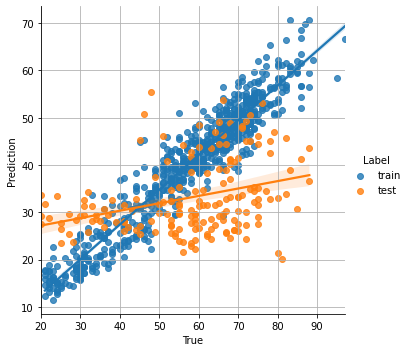

EPOCHS 59
L1   :: [TRAIN] 304.052 | [VALID] 1186.143
CORR :: [TRAIN] 0.952 | [VALID] -0.416


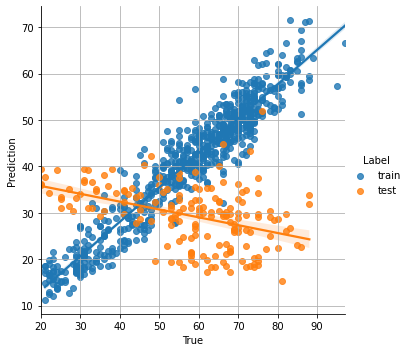

EPOCHS 60
L1   :: [TRAIN] 279.383 | [VALID] 1023.401
CORR :: [TRAIN] 0.950 | [VALID] -0.371


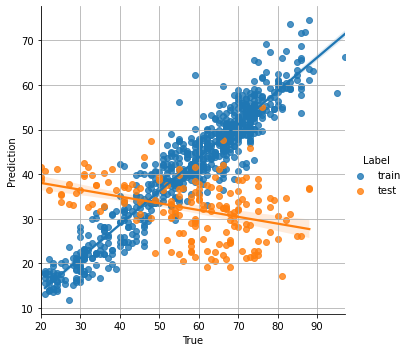

EPOCHS 61
L1   :: [TRAIN] 255.121 | [VALID] 244.060
CORR :: [TRAIN] 0.949 | [VALID] 0.714


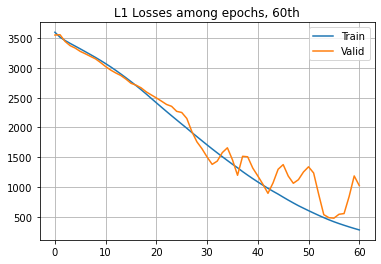

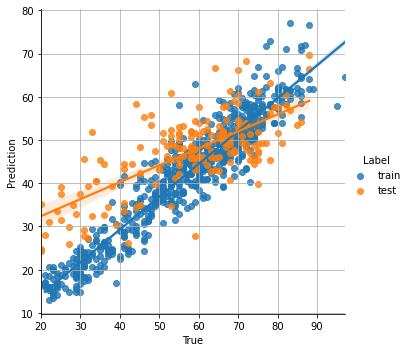

EPOCHS 62
L1   :: [TRAIN] 230.310 | [VALID] 224.519
CORR :: [TRAIN] 0.953 | [VALID] 0.752


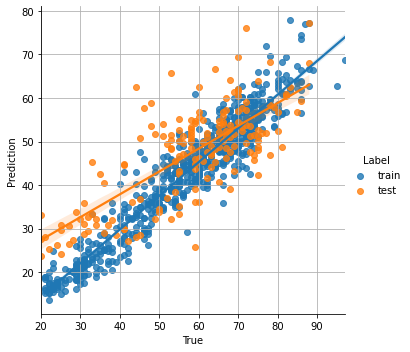

EPOCHS 63
L1   :: [TRAIN] 207.992 | [VALID] 352.325
CORR :: [TRAIN] 0.956 | [VALID] 0.654


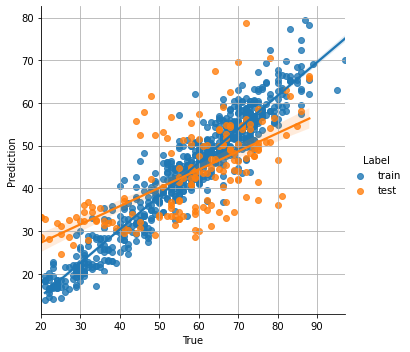

EPOCHS 64
L1   :: [TRAIN] 189.003 | [VALID] 534.775
CORR :: [TRAIN] 0.956 | [VALID] 0.368


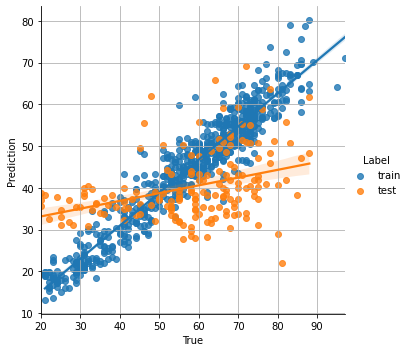

EPOCHS 65
L1   :: [TRAIN] 171.455 | [VALID] 427.573
CORR :: [TRAIN] 0.957 | [VALID] 0.684


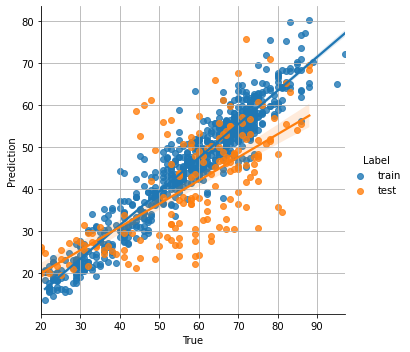

EPOCHS 66
L1   :: [TRAIN] 154.677 | [VALID] 262.385
CORR :: [TRAIN] 0.956 | [VALID] 0.783


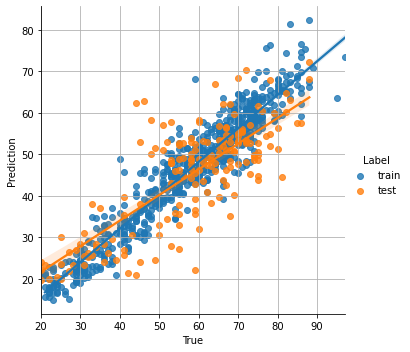

EPOCHS 67
L1   :: [TRAIN] 139.237 | [VALID] 423.481
CORR :: [TRAIN] 0.956 | [VALID] 0.679


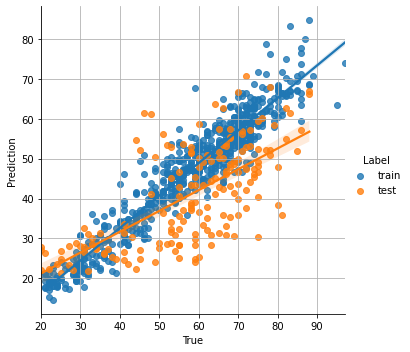

EPOCHS 68
L1   :: [TRAIN] 126.613 | [VALID] 370.538
CORR :: [TRAIN] 0.955 | [VALID] 0.684


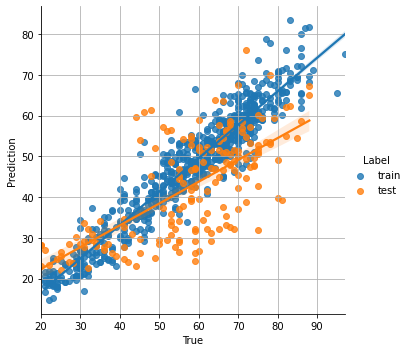

EPOCHS 69
L1   :: [TRAIN] 114.698 | [VALID] 305.996
CORR :: [TRAIN] 0.955 | [VALID] 0.727


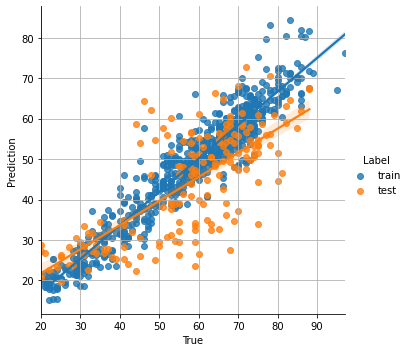

EPOCHS 70
L1   :: [TRAIN] 102.612 | [VALID] 420.358
CORR :: [TRAIN] 0.956 | [VALID] 0.633


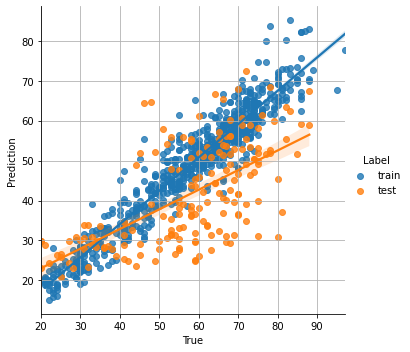

EPOCHS 71
L1   :: [TRAIN] 92.363 | [VALID] 397.586
CORR :: [TRAIN] 0.957 | [VALID] 0.673


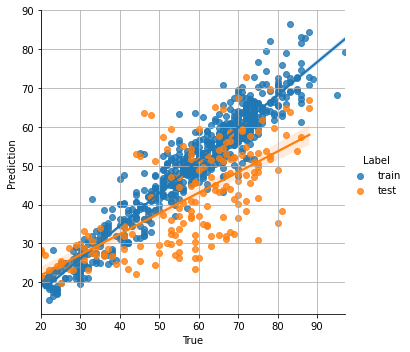

EPOCHS 72
L1   :: [TRAIN] 83.207 | [VALID] 472.237
CORR :: [TRAIN] 0.957 | [VALID] 0.604


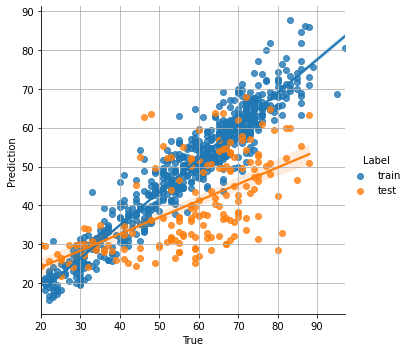

EPOCHS 73
L1   :: [TRAIN] 74.384 | [VALID] 454.890
CORR :: [TRAIN] 0.957 | [VALID] 0.567


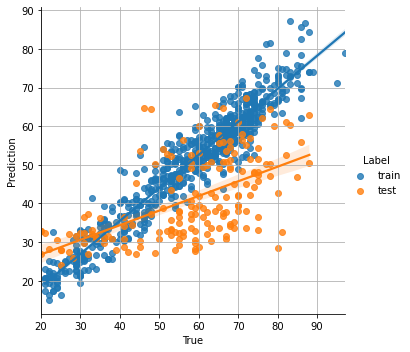

EPOCHS 74
L1   :: [TRAIN] 66.430 | [VALID] 193.737
CORR :: [TRAIN] 0.957 | [VALID] 0.759


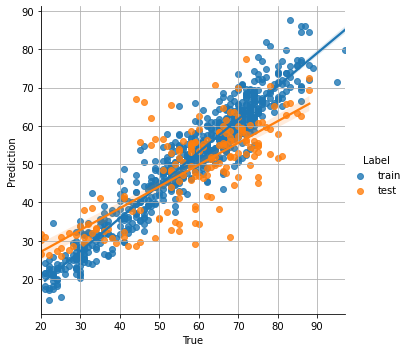

EPOCHS 75
L1   :: [TRAIN] 60.102 | [VALID] 134.248
CORR :: [TRAIN] 0.956 | [VALID] 0.721


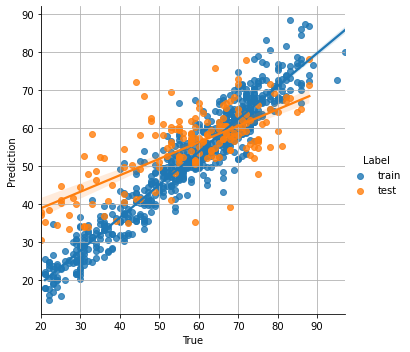

EPOCHS 76
L1   :: [TRAIN] 54.789 | [VALID] 136.715
CORR :: [TRAIN] 0.954 | [VALID] 0.696


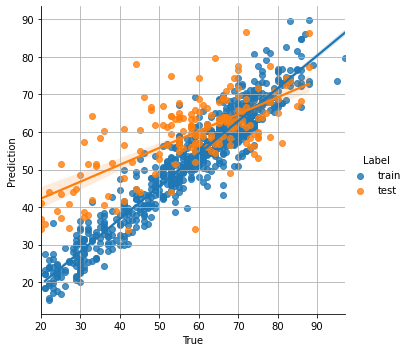

EPOCHS 77
L1   :: [TRAIN] 51.660 | [VALID] 172.641
CORR :: [TRAIN] 0.950 | [VALID] 0.639


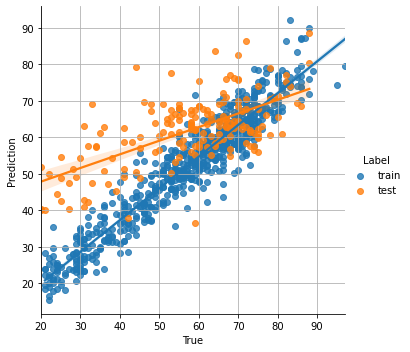

EPOCHS 78
L1   :: [TRAIN] 50.454 | [VALID] 116.575
CORR :: [TRAIN] 0.946 | [VALID] 0.759


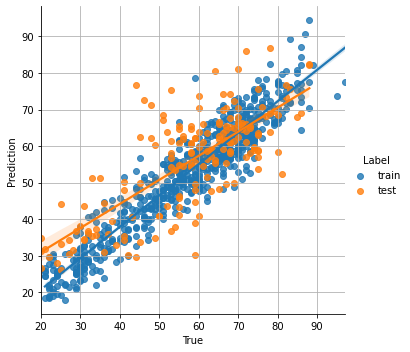

EPOCHS 79
L1   :: [TRAIN] 44.268 | [VALID] 121.701
CORR :: [TRAIN] 0.951 | [VALID] 0.737


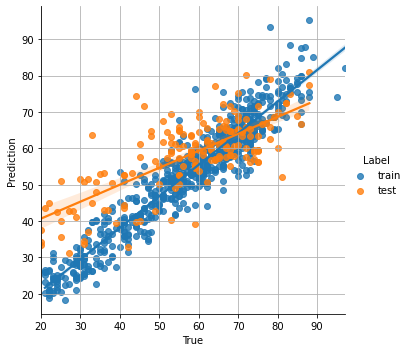

EPOCHS 80
L1   :: [TRAIN] 39.342 | [VALID] 111.846
CORR :: [TRAIN] 0.954 | [VALID] 0.797


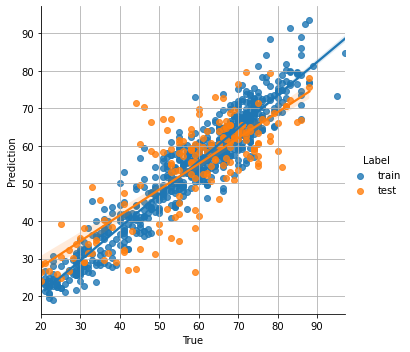

EPOCHS 81
L1   :: [TRAIN] 35.181 | [VALID] 161.194
CORR :: [TRAIN] 0.957 | [VALID] 0.779


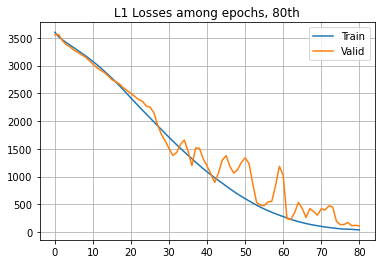

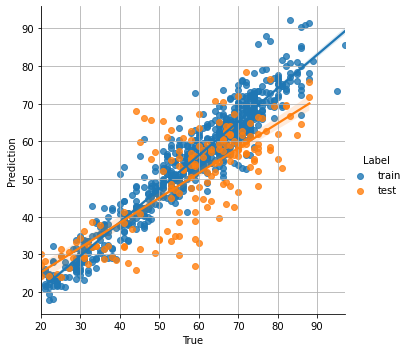

EPOCHS 82
L1   :: [TRAIN] 32.583 | [VALID] 164.162
CORR :: [TRAIN] 0.957 | [VALID] 0.758


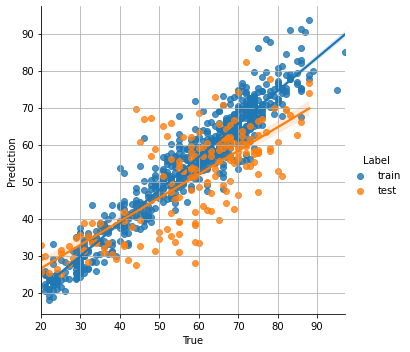

EPOCHS 83
L1   :: [TRAIN] 29.984 | [VALID] 106.520
CORR :: [TRAIN] 0.959 | [VALID] 0.788


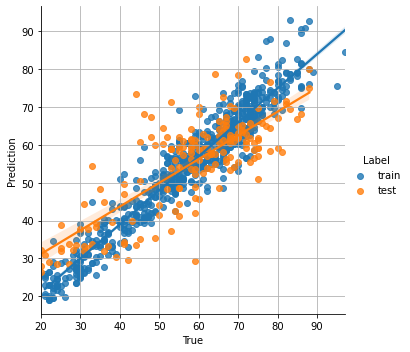

EPOCHS 84
L1   :: [TRAIN] 28.124 | [VALID] 99.828
CORR :: [TRAIN] 0.959 | [VALID] 0.789


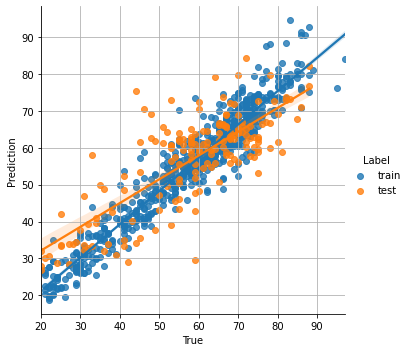

EPOCHS 85
L1   :: [TRAIN] 26.521 | [VALID] 100.324
CORR :: [TRAIN] 0.960 | [VALID] 0.784


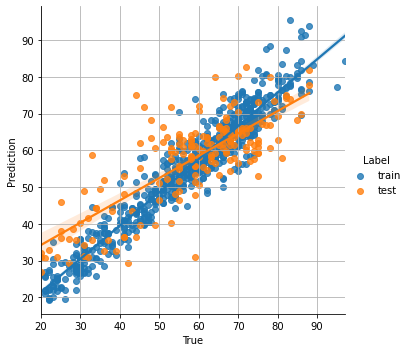

EPOCHS 86
L1   :: [TRAIN] 25.458 | [VALID] 106.854
CORR :: [TRAIN] 0.960 | [VALID] 0.772


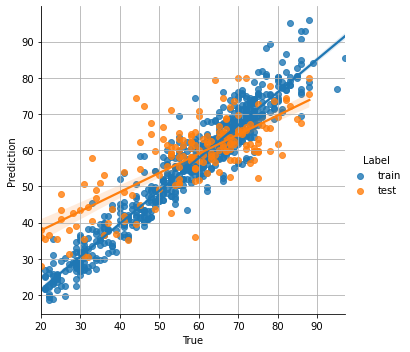

EPOCHS 87
L1   :: [TRAIN] 24.661 | [VALID] 99.887
CORR :: [TRAIN] 0.960 | [VALID] 0.787


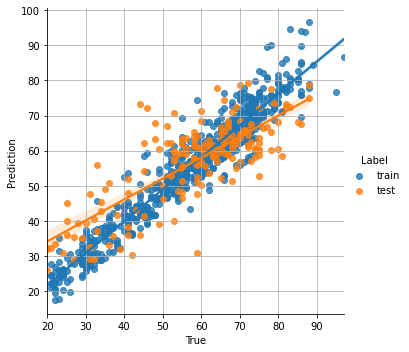

EPOCHS 88
L1   :: [TRAIN] 23.950 | [VALID] 98.669
CORR :: [TRAIN] 0.960 | [VALID] 0.792


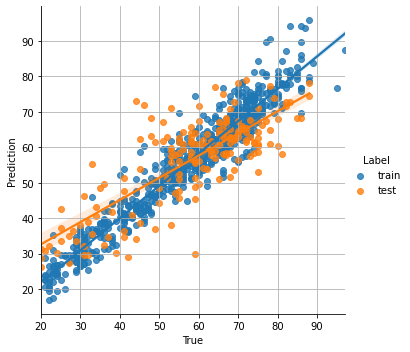

EPOCHS 89
L1   :: [TRAIN] 23.331 | [VALID] 105.590
CORR :: [TRAIN] 0.960 | [VALID] 0.776


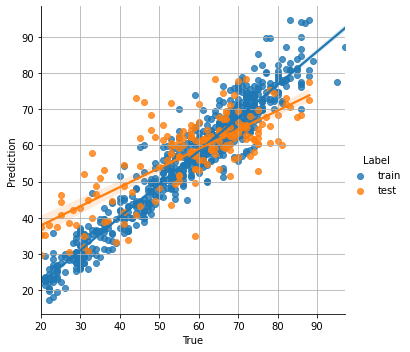

EPOCHS 90
L1   :: [TRAIN] 22.749 | [VALID] 133.333
CORR :: [TRAIN] 0.960 | [VALID] 0.737


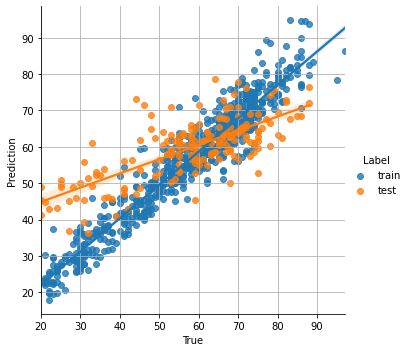

EPOCHS 91
L1   :: [TRAIN] 22.455 | [VALID] 113.962
CORR :: [TRAIN] 0.960 | [VALID] 0.757


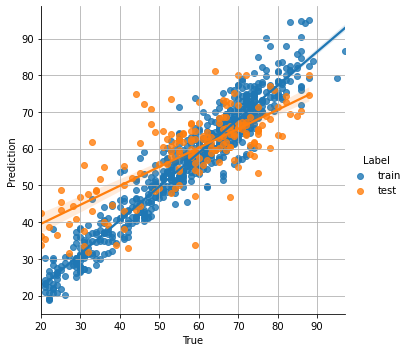

EPOCHS 92
L1   :: [TRAIN] 22.328 | [VALID] 103.778
CORR :: [TRAIN] 0.960 | [VALID] 0.782


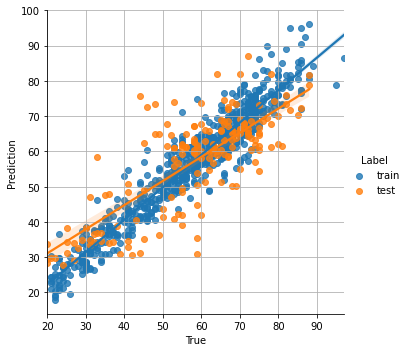

EPOCHS 93
L1   :: [TRAIN] 22.308 | [VALID] 125.220
CORR :: [TRAIN] 0.960 | [VALID] 0.770


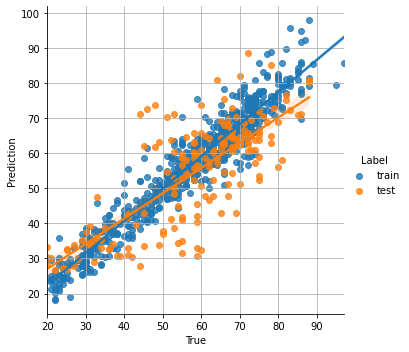

EPOCHS 94
L1   :: [TRAIN] 22.434 | [VALID] 180.241
CORR :: [TRAIN] 0.959 | [VALID] 0.735


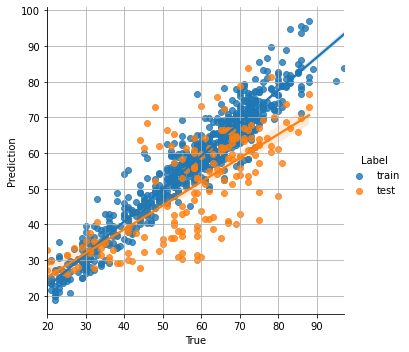

EPOCHS 95
L1   :: [TRAIN] 22.719 | [VALID] 96.996
CORR :: [TRAIN] 0.959 | [VALID] 0.791


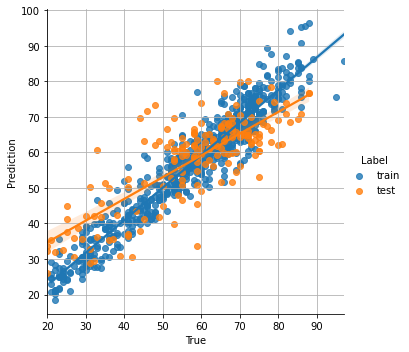

EPOCHS 96
L1   :: [TRAIN] 23.104 | [VALID] 122.117
CORR :: [TRAIN] 0.958 | [VALID] 0.781


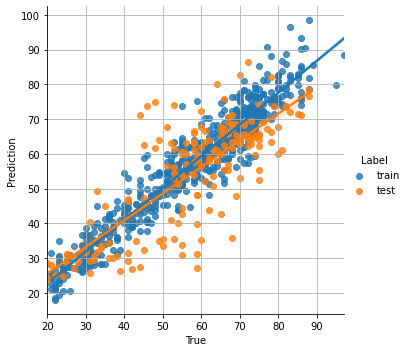

EPOCHS 97
L1   :: [TRAIN] 23.184 | [VALID] 343.549
CORR :: [TRAIN] 0.958 | [VALID] 0.659


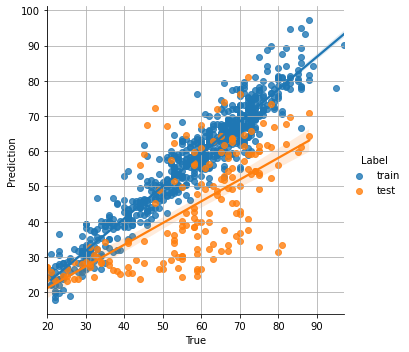

EPOCHS 98
L1   :: [TRAIN] 23.241 | [VALID] 118.661
CORR :: [TRAIN] 0.958 | [VALID] 0.778


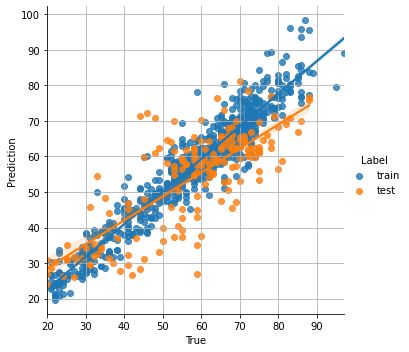

EPOCHS 99
L1   :: [TRAIN] 23.505 | [VALID] 290.978
CORR :: [TRAIN] 0.957 | [VALID] 0.702


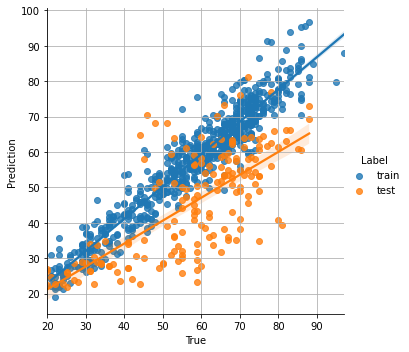

EPOCHS 100
L1   :: [TRAIN] 23.594 | [VALID] 159.943
CORR :: [TRAIN] 0.957 | [VALID] 0.765


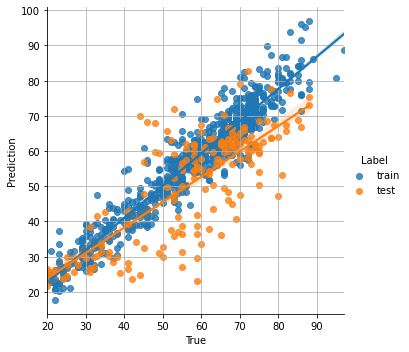

EPOCHS 101
L1   :: [TRAIN] 23.890 | [VALID] 156.617
CORR :: [TRAIN] 0.956 | [VALID] 0.743


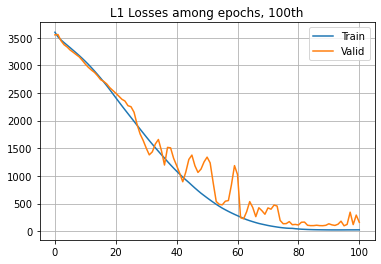

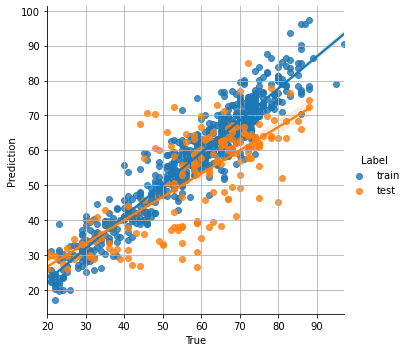

EPOCHS 102
L1   :: [TRAIN] 23.362 | [VALID] 134.246
CORR :: [TRAIN] 0.957 | [VALID] 0.752


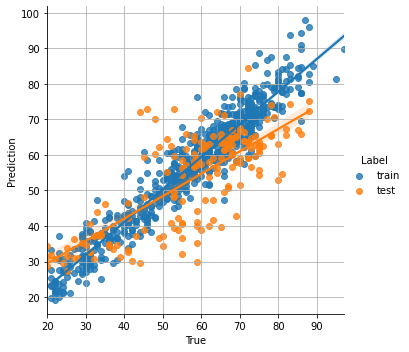

EPOCHS 103
L1   :: [TRAIN] 23.737 | [VALID] 102.058
CORR :: [TRAIN] 0.956 | [VALID] 0.780


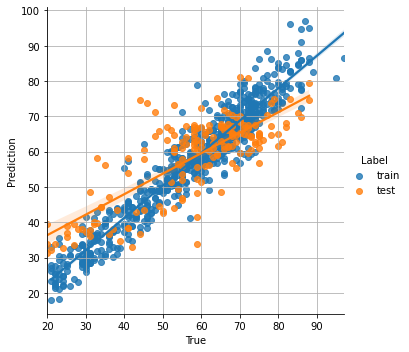

EPOCHS 104
L1   :: [TRAIN] 23.346 | [VALID] 113.391
CORR :: [TRAIN] 0.957 | [VALID] 0.767


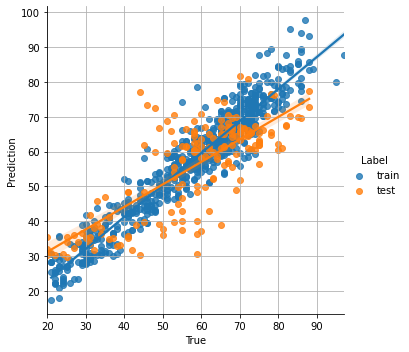

EPOCHS 105
L1   :: [TRAIN] 23.533 | [VALID] 131.203
CORR :: [TRAIN] 0.957 | [VALID] 0.751


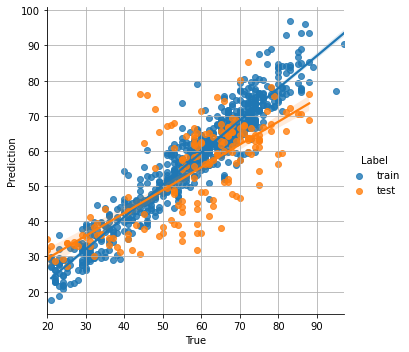

EPOCHS 106
L1   :: [TRAIN] 23.992 | [VALID] 107.313
CORR :: [TRAIN] 0.956 | [VALID] 0.774


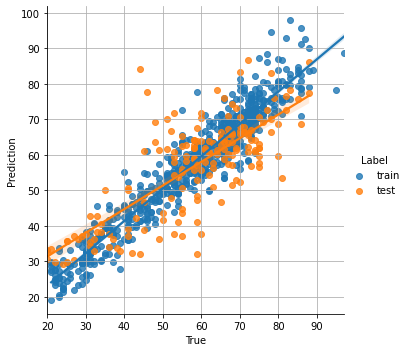

EPOCHS 107
L1   :: [TRAIN] 22.965 | [VALID] 114.792
CORR :: [TRAIN] 0.958 | [VALID] 0.747


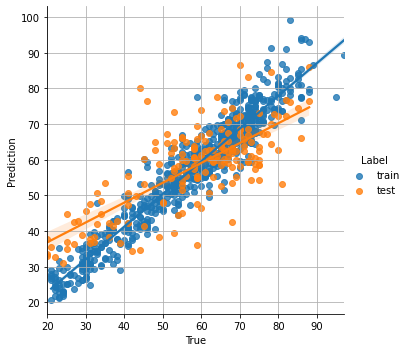

EPOCHS 108
L1   :: [TRAIN] 22.774 | [VALID] 117.418
CORR :: [TRAIN] 0.958 | [VALID] 0.746


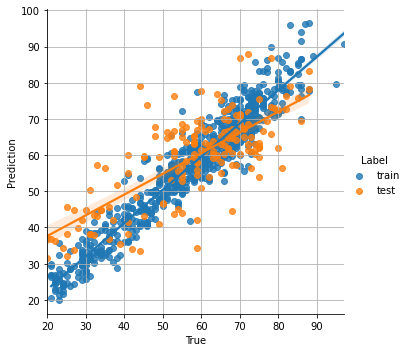

EPOCHS 109
L1   :: [TRAIN] 21.514 | [VALID] 129.151
CORR :: [TRAIN] 0.961 | [VALID] 0.741


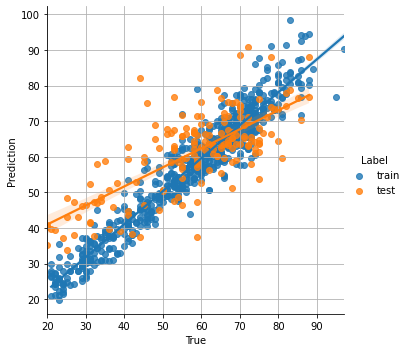

EPOCHS 110
L1   :: [TRAIN] 22.246 | [VALID] 129.322
CORR :: [TRAIN] 0.959 | [VALID] 0.741


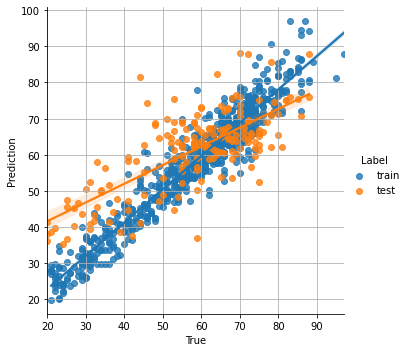

In [ ]:
trn_losses, tst_losses = [], []
best_loss = 10

for e in range(300):

    # TRAIN
    trn_bth_loss = 0
    trn_trues, trn_preds = [], []
    model.train()
    for i, (x, y) in enumerate(train_loader):

        if resize:
            x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

        else:
            x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x).to(device)

        trn_trues.append(y.to('cpu'))
        trn_preds.append(y_pred.to('cpu'))

#         loss = torch.sqrt(loss_fn(y_pred.squeeze(1), y)) # <- for MSE -> RMSE
        loss = loss_fn(y_pred.squeeze(1), y)
        del x, y, y_pred

        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()

        trn_bth_loss += loss.item()

    torch.cuda.empty_cache()
    
    ### loss
    trn_losses.append(trn_bth_loss / len(train_loader))

    ### collect trues/predictions
    trn_trues = list(chain(*trn_trues))
    trn_preds = list(chain(*trn_preds))

        
    # TEST
    tst_bth_loss = 0
    model.eval()
    tst_trues, tst_preds = [], []
    with torch.no_grad(): # to not give loads on GPU... :(
        for i, (x, y) in enumerate(test_loader):
            if resize:
                x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

            else:
                x, y = x.to(device), y.to(device)

            y_pred = model.forward(x).to(device)

            tst_trues.append(y.to('cpu'))
            tst_preds.append(y_pred.to('cpu'))

#             loss = torch.sqrt(loss_fn(y_pred.squeeze(1), y)) # <- for MSE -> RMSE
            loss = loss_fn(y_pred.squeeze(1), y)
            del x, y, y_pred

            tst_bth_loss += loss.item()

    torch.cuda.empty_cache()
    ### loss
    tst_losses.append(tst_bth_loss / len(test_loader))

    ### collect trues/predictions
    tst_trues = list(chain(*tst_trues))
    tst_preds = list(chain(*tst_preds))
    
    reg_df = pd.DataFrame({
        'True': list(map(float, trn_trues + tst_trues)),
        'Prediction': list(map(float, trn_preds + tst_preds)),
        'Label': ['train'] * len(trn_trues) + ['test'] * len(tst_trues)
    })
    
    trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
    tst_corr = reg_df[reg_df['Label'] == 'test' ].corr().Prediction['True']

    print(f'EPOCHS {e}')
    print(f'L1   :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
    print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}')
    
    sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
    plt.grid()
    plt.show()
    
    if best_loss - .02 > tst_losses[-1]:
        
        date = f'{datetime.now().strftime("%Y-%m-%d_%H%M")}'
        fname = f"./models/{date}_{tst_losses[-1]:.3f}_model.pth"
        torch.save(model, fname)
        best_loss = min(tst_losses[-1], best_loss)
        
    summary.add_scalars('loss/RMSE_loss',
                         {'Train Loss': trn_losses[-1],
                          'Valid Loss': tst_losses[-1]}, e)
    summary.add_scalars('corr',
                       {'Train Correlation': trn_corr,
                        'Valid Correlation': tst_corr,
                        'Total Correlation': reg_df.corr().Prediction['True']}, e)
    
    if e % 20 == 0:
        plt.plot(trn_losses, label='Train')
        plt.plot(tst_losses, label='Valid')
        plt.title(f"L1 Losses among epochs, {e}th")
        #plt.ylim(0, 500)
        plt.grid()
        plt.legend()

In [ ]:
best_loss

In [ ]:
# %load ../2d_slice/src/slice_viewer.py

In [ ]:
# SliceViewer(np.array(train_dset[0][0][0])).triple_view()